In [1]:
import os
import sys
sys.path.append('../')

from helpers import helper
from dataloaders import dataloader
from networks import Unet
from networks import VGG_conv3x3
from networks import transformer
import config

import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

device = config.get_device()
trainset, train_dl = dataloader.getData('../../datasets/train.csv', batch_size=4, transform=config.transform, num_workers=config.num_workers)
testset, test_dl = dataloader.getData('../../datasets/test.csv', batch_size=4, transform=config.transform, num_workers=config.num_workers)

Using device: cuda


Load model from ../models/unet_32.pth
Model saved to ../models/unet_32.pth
Input shape: torch.Size([4, 3, 256, 256])
Output shape torch.Size([4, 2, 256, 256])
loss: 518.3720703125


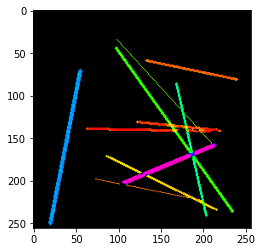

In [2]:
network = Unet.get_model(features=32,model_path='../models/unet_32.pth')
network.save()
def test(decoder, dataloader):
    decoder.to(device)
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        print("Input shape:", images.shape)
        outputs = decoder(images)

        helper.plot_tensor_output(outputs[0])
        print("Output shape", outputs.shape)
        break

    loss = nn.MSELoss(reduction='sum')(outputs, labels)
    loss.backward()
    print(f'loss: {loss.item()}')
    
test(network, test_dl)

In [4]:
def train_one_epoch(network, train_dl, criterion, optimizer, scaler, device):
    network.train()
    train_loss = 0.0
    for images, labels in train_dl:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            output = network(images)
            loss = criterion(output, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss
        del output
        del loss
    # Decay LR by a factor of 0.1 every 2 epochs
    # exp_lr_scheduler.step()
    return train_loss/len(train_dl)

def test(network, val_dl, criterion, device):
    network.eval()
    val_loss = 0.0
    for images, labels in val_dl:
        images = images.to(device)
        labels = labels.to(device)
        output = network(images)
        loss = criterion(output, labels)
        val_loss += loss
        del output
        del loss
    return val_loss/len(val_dl) 

Train_loss = []
Test_loss = []

def train(network, train_dl, test_dl, device, epochs, lr=0.001):
    network.to(device)
    network.train()

    criterion = nn.MSELoss(reduction="sum")
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(epochs):
        optimizer = torch.optim.Adam(network.parameters(), lr)
        print('Epoch {}/{}'.format(epoch+1, epochs))
        train_loss = train_one_epoch(network, train_dl, criterion, optimizer, scaler, device)
        Train_loss.append(train_loss)

        with torch.no_grad():
            test_loss = test(network, test_dl, criterion, device)
        Test_loss.append(test_loss)

        print('Train Loss: {:.4f}; Test Loss: {:.4f}'.format(train_loss, test_loss))
        network.save()


train(network, train_dl, test_dl, device, 1, lr=0.001)

Epoch 1/1
Train Loss: 528.6265; Test Loss: 630.9056
Model saved to ../models/unet_32.pth


In [31]:
# save train loss and test loss in a csv file named 'loss_{network_dir}.txt'
import pandas as pd
for loss in Train_loss:
    loss = loss.cpu().detach().numpy()
for loss in Test_loss:
    loss = loss.cpu().detach().numpy()

df = pd.DataFrame({'train_loss': Train_loss.cpu(), 'test_loss': Test_loss.cpu()})
df.to_csv(f'../../datasets/experiment//loss_{network.get_network_dir}.csv', index=False)

AttributeError: 'list' object has no attribute 'cpu'

In [25]:
Train_loss

[tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)]

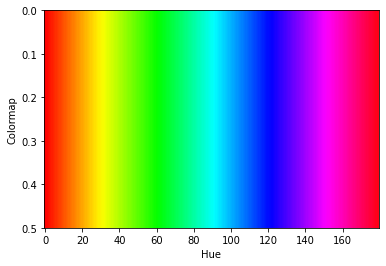

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of values ranging from 0 to 1
hue_values = np.linspace(0, 1, 180)

# Create a colormap using the 'hsv' color space with the hue values
colormap = plt.get_cmap('hsv')

# Create a figure and axis
fig, ax = plt.subplots()


# Plot the colormap using a colorbar
ax.imshow([hue_values], cmap=colormap, aspect='auto')
# set axis labels
ax.set_xlabel('Hue')
ax.set_ybound([0, 0.5])
ax.set_ylabel('Colormap')

# Display the plot
plt.show()

